# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [8]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
import numpy as np

In [9]:
random.random()

0.42804371907923056

In [59]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = np.random.normal(700, 100)
  purchased = random.random() < 0.1 + (time_on_site / 1500) #Boolean based on probability and time on site
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(200, 90)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users) #unbias any streak of samples
print(users[:10])

[User(purchased=False, time_on_site=266.50676533335536, mobile=True), User(purchased=False, time_on_site=216.73736914902338, mobile=True), User(purchased=True, time_on_site=284.4740786489758, mobile=True), User(purchased=True, time_on_site=252.01458167660334, mobile=True), User(purchased=True, time_on_site=219.9570166125779, mobile=True), User(purchased=False, time_on_site=182.32136162637102, mobile=True), User(purchased=False, time_on_site=227.4409414855245, mobile=True), User(purchased=True, time_on_site=150.38253483098097, mobile=True), User(purchased=True, time_on_site=672.392504780361, mobile=False), User(purchased=False, time_on_site=300.4621977596646, mobile=True)]


In [60]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,266.506765,True
1,False,216.737369,True
2,True,284.474079,True
3,True,252.014582,True
4,True,219.957017,True


In [62]:
user_data.sample(n=10)

,purchased,time_on_site,mobile
536,False,713.754100,False
625,True,706.220792,False
74,False,280.160559,True
998,True,102.927162,True
110,True,198.646857,True
705,False,125.530585,True
253,True,232.576466,True
907,True,625.335103,False
236,False,258.344951,True
764,True,752.297357,False


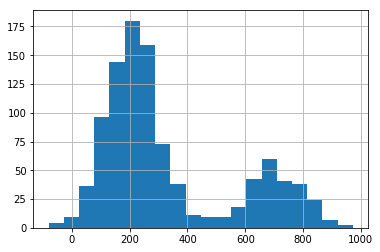

In [63]:
user_data['time_on_site'].hist(bins=20)

In [64]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-80.92567906089505,-71.75964743897003,-47.7831980505276,-33.239013394543065,-14.99480853820694,-10.717737276958644,-6.687404082711112,-5.688044823112278,5.048666801537422,8.32564557079695,...,859.0799001005516,871.8457318365332,890.89926583272,890.9748697632206,899.0720683203823,913.8747321124958,915.2199579021026,917.4248524049733,939.4326049357386,972.5757919309318
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,0,0,1,1,1,0,1,1,1,...,1,1,1,0,1,0,0,0,0,0
True,1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,1,1,1


In [0]:
#Fix unrealistic time on site
idx = user_data['time_on_site'] < 0
user_data.loc[idx,'time_on_site'] = np.NaN

#Or try by pandas ''.where' method

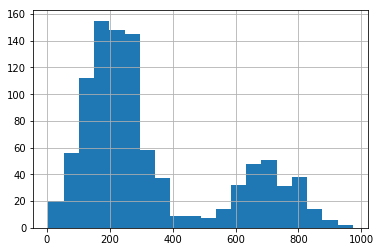

In [66]:
user_data['time_on_site'].hist(bins=20)

In [54]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

#Always a quick look at data in buckets

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins,user_data['purchased'])

purchased,False,True
time_on_site,,
"(96.331, 276.394]",38,31
"(276.394, 455.562]",224,273
"(455.562, 634.73]",100,133
"(634.73, 813.898]",62,110
"(813.898, 993.066]",7,22


In [55]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins,user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(96.331, 276.394]",0.088167,0.054482
"(276.394, 455.562]",0.519722,0.479789
"(455.562, 634.73]",0.232019,0.233743
"(634.73, 813.898]",0.143852,0.193322
"(813.898, 993.066]",0.016241,0.038664


In [56]:
# What if we normalize by row
pd.crosstab(time_bins,user_data['purchased'], normalize='index')

purchased,False,True
time_on_site,,
"(96.331, 276.394]",0.550725,0.449275
"(276.394, 455.562]",0.450704,0.549296
"(455.562, 634.73]",0.429185,0.570815
"(634.73, 813.898]",0.360465,0.639535
"(813.898, 993.066]",0.241379,0.758621


In [57]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.4,0.441333
True,0.6,0.558667


In [58]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins,[user_data['mobile'],user_data['purchased']], normalize='all')

mobile              False         True        
purchased           False  True   False  True 
time_on_site                                  
(96.331, 276.394]   0.000  0.000  0.038  0.031
(276.394, 455.562]  0.002  0.001  0.222  0.272
(455.562, 634.73]   0.031  0.022  0.069  0.111
(634.73, 813.898]   0.060  0.105  0.002  0.005
(813.898, 993.066]  0.007  0.022  0.000  0.000

In [70]:
df = pd.DataFrame({'a': np.arange(1e5), 'b':2*np.arange(1e5)})
df.head()

,a,b
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0


In [77]:
%%timeit 
#apparently .apply command is slow
df['c'] = df['a'].apply(lambda x: x**2)

10 loops, best of 3: 29.9 ms per loop


In [76]:
%%timeit
df['c2'] = df['a']**2

1000 loops, best of 3: 1.62 ms per loop


In [74]:
df.head()

,a,b,c
0,0.0,0.0,0.0
1,1.0,2.0,1.0
2,2.0,4.0,4.0
3,3.0,6.0,9.0
4,4.0,8.0,16.0


In [0]:
def get_temp_for_coord(x,y):
  "..."
  temp = 60
  return temp

In [0]:
df['temp'] = df.apply(lambda x: get temp_for_coord(x['lat'],x['lon']))

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [91]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

df = pd.read_csv('https://raw.githubusercontent.com/martinclehman/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
df.drop(columns=['Unnamed: 0'], inplace=True)
#or df = df.dropp(columns=['Unnamed: 0'])

In [93]:
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
#Alternative way if you want to drop the index column and save to local collab
#df.to_csv("path_to_my_csv_file.csv", index=False)
#!ls

In [95]:
df.dtypes.value_counts()

int64    3
dtype: int64

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


In [0]:
#for more advanced, lookup numpy.corrcoef
#Hint: make correlations between variables
#Hint #3: what if there's correlation and you can't explain why...

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)